# Training: Hybrid Model v2:
- dataset cambiado :S
- Pets + Supermarket skus
- Bert Multi Model Base


In [ ]:
!pip install unidecode Unidecode==1.3.6 google-cloud-aiplatform transformers==4.40.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


## libs

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
import requests
from collections import Counter
import re
import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import time

import glob
from ast import literal_eval

import io
import math

import warnings
warnings.filterwarnings("ignore")

from numpy.linalg import norm
from matplotlib import colors

import pickle

import json


#from password import *

from vertexai.preview.language_models import TextEmbeddingModel
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'automatch-309218-5f83b019f742.json'

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from transformers import BertTokenizer, TFBertModel
from transformers import AdamW, AdamWeightDecay, WarmUp
#import tensorflow_text as text

import warnings
warnings.filterwarnings("ignore")
#tf.debugging.set_log_device_placement(True)

## TPU

In [ ]:
##para configuracion TPU

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
#if tf.config.list_physical_devices('GPU'):
#  strategy = tf.distribute.MirroredStrategy()
#  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

Using TPU


## GCP Credentials

In [ ]:
project_id = 'automatch-309218'
!gcloud config set project {project_id}

!gcloud auth login
!gcloud auth application-default login

REGION = "us-central1"
BUCKET_URI = 'gs://pets-match-v2-21-12-23'
FOLDER_MODEL = 'hybrid_model_v2'
FOLDER_DATASETS = 'datasets'
TF_RECORDS_DATASETS = 'tf_records_ds'

Updated property [core/project].
Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=3SvEhjAyCwxxMU3HnS3i4kjRmdbz5q&prompt=consent&token_usage=remote&access_type=offline&code_challenge=TUWqMZmSAOrWdtmP2yRjHOkZHlVEiq5nUzCMVkifmgc&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0ATx3LY5nuLcIUKK2VtX4s80gZuZeg37WC0CkxL8JQXlLvdo_7FVvTcHiQ2BB74LAF4rxFw

You are now logged in as [ia@geti.cl].

## GCP Txt embedding model

In [ ]:
embedding_model_gcp = TextEmbeddingModel.from_pretrained("textembedding-gecko@003")

def get_embedding_txt_gcp(text, model=embedding_model_gcp):
    """returns the embedding for a string using gcp embedding model"""
    text = text.replace("\n", " ")
    embedding = model.get_embeddings([text])
    embedding = embedding[0].values
    return embedding

## Bert Modal & tokenizer

In [ ]:
#BERT multi

bert_multi = 'bert-base-multilingual-uncased'
#Loading tokenizer
tokenizer= BertTokenizer.from_pretrained(bert_multi)

MAX_LENGTH = 35

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
def join_products(product_1, product_2):
  join = [f'{p1} [SEP] {p2}' for p1,p2 in zip(product_1,product_2)]
  return join

# Training v2
dataset filtrando malos match, filtrando datos redundantes

## Dataset en TF Records ALL

In [ ]:
!gsutil cp {BUCKET_URI}/{FOLDER_MODEL}/{FOLDER_DATASETS}/ds_training_v2_240624.csv .
!gsutil cp {BUCKET_URI}/{FOLDER_MODEL}/{FOLDER_DATASETS}/ds_evaluating_v2_240624.csv .
!gsutil cp {BUCKET_URI}/{FOLDER_MODEL}/{FOLDER_DATASETS}/ds_testing_v2_240624.csv .


Copying gs://pets-match-v2-21-12-23/hybrid_model_v2/datasets/ds_training_v2_240624.csv...
/ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Copying gs://pets-match-v2-21-12-23/hybrid_model_v2/datasets/ds_evaluating_v2_240624.csv...
/ [1 files][260.8 KiB/260.8 KiB]                                                
Operation completed over 1 objects/260.8 KiB.                                    
Copying gs://pets-match-v2-21-12-23/hybrid_model_v2/datasets/ds_testing_v2_240624.csv...
/ [1 files][260.1 KiB/260.1 KiB]                                                
Operation completed over 1 objects/260.1 KiB.                                    


In [ ]:
ds_train = pd.read_csv('ds_training_v2_240624.csv', index_col=0)
ds_eval = pd.read_csv('ds_evaluating_v2_240624.csv', index_col=0)
ds_test = pd.read_csv('ds_testing_v2_240624.csv', index_col=0)

In [ ]:
def decode_fn2(sample, max_length=MAX_LENGTH):
    features = {
        "input_ids": tf.io.FixedLenFeature((max_length,), dtype=tf.int64),
        "attention_mask": tf.io.FixedLenFeature((max_length,), dtype=tf.int64),
        #"token_type_ids": tf.io.FixedLenFeature((max_length,), dtype=tf.int64),
    }
    labels = {
        "labels": tf.io.FixedLenFeature((1,), dtype=tf.int64)
    }
    x = tf.io.parse_example(sample, features)
    y = tf.io.parse_example(sample, labels)

    return ((x),y)

def generate_tfrecords_data(chunk_ds, chunk_labels, file_name, max_length=MAX_LENGTH ):
  #chunk:
  tokenized_data = tokenizer(
      list(chunk_ds),
      padding="max_length",
      truncation=True,
      max_length=max_length,
      return_tensors="np",
  )

  labels = chunk_labels #already in numpy array

  with tf.io.TFRecordWriter(f"{file_name}.tfrecords") as file_writer:
    for i in range(len(labels)):
        features = {
            "input_ids": tf.train.Feature(
                int64_list=tf.train.Int64List(value=tokenized_data["input_ids"][i])
            ),
            "attention_mask": tf.train.Feature(
                int64_list=tf.train.Int64List(value=tokenized_data["attention_mask"][i])
            ),
            #"token_type_ids": tf.train.Feature(
            #    int64_list=tf.train.Int64List(value=tokenized_data["token_type_ids"][i])
            #),
            "labels": tf.train.Feature(
                int64_list=tf.train.Int64List(value=[labels[i]])
            ),
        }
        features = tf.train.Features(feature=features)
        example = tf.train.Example(features=features)
        record_bytes = example.SerializeToString()
        file_writer.write(record_bytes)

In [ ]:
len(ds_train), len(ds_eval), len(ds_test)

(41794, 2587, 2586)

## Dataset en TF Records Training--> 50% sample

In [ ]:
!gsutil cp {BUCKET_URI}/{FOLDER_MODEL}/{FOLDER_DATASETS}/ds_training_v2_240624_sample.csv .  ##OJOOO un 50% sample
!gsutil cp {BUCKET_URI}/{FOLDER_MODEL}/{FOLDER_DATASETS}/ds_evaluating_v2_240624.csv .
!gsutil cp {BUCKET_URI}/{FOLDER_MODEL}/{FOLDER_DATASETS}/ds_testing_v2_240624.csv .


Copying gs://pets-match-v2-21-12-23/hybrid_model_v2/datasets/ds_training_v2_240624_sample.csv...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      
Copying gs://pets-match-v2-21-12-23/hybrid_model_v2/datasets/ds_evaluating_v2_240624.csv...
/ [1 files][260.8 KiB/260.8 KiB]                                                
Operation completed over 1 objects/260.8 KiB.                                    
Copying gs://pets-match-v2-21-12-23/hybrid_model_v2/datasets/ds_testing_v2_240624.csv...
/ [1 files][260.1 KiB/260.1 KiB]                                                
Operation completed over 1 objects/260.1 KiB.                                    


In [ ]:
ds_train_sample = pd.read_csv('ds_training_v2_240624_sample.csv', index_col=0)
ds_eval = pd.read_csv('ds_evaluating_v2_240624.csv', index_col=0)
ds_test = pd.read_csv('ds_testing_v2_240624.csv', index_col=0)

In [ ]:
len(ds_train_sample), len(ds_eval), len(ds_test)

(20897, 2587, 2586)

In [ ]:
def decode_fn2(sample, max_length=MAX_LENGTH):
    features = {
        "input_ids": tf.io.FixedLenFeature((max_length,), dtype=tf.int64),
        "attention_mask": tf.io.FixedLenFeature((max_length,), dtype=tf.int64),
        #"token_type_ids": tf.io.FixedLenFeature((max_length,), dtype=tf.int64),
    }
    labels = {
        "labels": tf.io.FixedLenFeature((1,), dtype=tf.int64)
    }
    x = tf.io.parse_example(sample, features)
    y = tf.io.parse_example(sample, labels)

    return ((x),y)

def generate_tfrecords_data(chunk_ds, chunk_labels, file_name, max_length=MAX_LENGTH ):
  #chunk:
  tokenized_data = tokenizer(
      list(chunk_ds),
      padding="max_length",
      truncation=True,
      max_length=max_length,
      return_tensors="np",
  )

  labels = chunk_labels #already in numpy array

  with tf.io.TFRecordWriter(f"{file_name}.tfrecords") as file_writer:
    for i in range(len(labels)):
        features = {
            "input_ids": tf.train.Feature(
                int64_list=tf.train.Int64List(value=tokenized_data["input_ids"][i])
            ),
            "attention_mask": tf.train.Feature(
                int64_list=tf.train.Int64List(value=tokenized_data["attention_mask"][i])
            ),
            #"token_type_ids": tf.train.Feature(
            #    int64_list=tf.train.Int64List(value=tokenized_data["token_type_ids"][i])
            #),
            "labels": tf.train.Feature(
                int64_list=tf.train.Int64List(value=[labels[i]])
            ),
        }
        features = tf.train.Features(feature=features)
        example = tf.train.Example(features=features)
        record_bytes = example.SerializeToString()
        file_writer.write(record_bytes)

## Model 1 v1 - AdamW
guardar como: model_v{version}_{batch_size}_{epochs}_{extra} <br>
- batch size: 32
- epochs: 10
- extra: no
- warmup: 10%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 32


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture

def model_v1(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt) #changed from 0.4 to 0.25

    #fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 10

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_txt_1_adamw = model_v1(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_v1_{BATCH_SIZE}_{NUM_EPOCHS}_loss.h5'
    filepath2 = f'model_v1_{BATCH_SIZE}_{NUM_EPOCHS}_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(0.1 * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_txt_1_adamw.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_txt_1_adamw.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7bfb8d5ff0d0> False
1 <keras.engine.input_layer.InputLayer object at 0x7bfb8cedfd00> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7bfb8d5d6bf0> False
3 <keras.layers.pooling.global_max_pooling1d.GlobalMaxPooling1D object at 0x7bfb8d415f30> True
4 <keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D object at 0x7bfb8d419f30> True
5 <keras.layers.merging.concatenate.Concatenate object at 0x7bfb8d4588e0> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bfb8cdd3340> True
7 <keras.layers.core.dense.Dense object at 0x7bfb8d535ba0> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bfb8ca30550> True
9 <keras.layers.regularization.dropout.Dropout object at 0x7bfb8ca743d0> True
10 <keras.layers.core.dense.Dense object at 0x7bfb8ced5990> True
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bf

In [ ]:
start = time.time()


history_1 = model_txt_1_adamw.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/10


1306/1306 [==============================] - ETA: 0s - loss: 0.8272 - accuracy: 0.5915 - auc: 0.6313 - precision: 0.5974 - recall: 0.5869
Epoch 1: val_loss improved from inf to 0.38568, saving model to model_v1_32_10_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.84023, saving model to model_v1_32_10_acc.h5
1306/1306 [==============================] - 211s 102ms/step - loss: 0.8272 - accuracy: 0.5915 - auc: 0.6313 - precision: 0.5974 - recall: 0.5869 - val_loss: 0.3857 - val_accuracy: 0.8402 - val_auc: 0.9305 - val_precision: 0.7870 - val_recall: 0.9214
Epoch 2/10
1306/1306 [==============================] - ETA: 0s - loss: 0.4912 - accuracy: 0.7938 - auc: 0.8711 - precision: 0.8032 - recall: 0.7839
Epoch 2: val_loss improved from 0.38568 to 0.19457, saving model to model_v1_32_10_loss.h5

Epoch 2: val_accuracy improved from 0.84023 to 0.92500, saving model to model_v1_32_10_acc.h5
1306/1306 [==============================] - 133s 102ms/step - loss: 0.4912 - accuracy: 0.7938 - 

### Evaluating

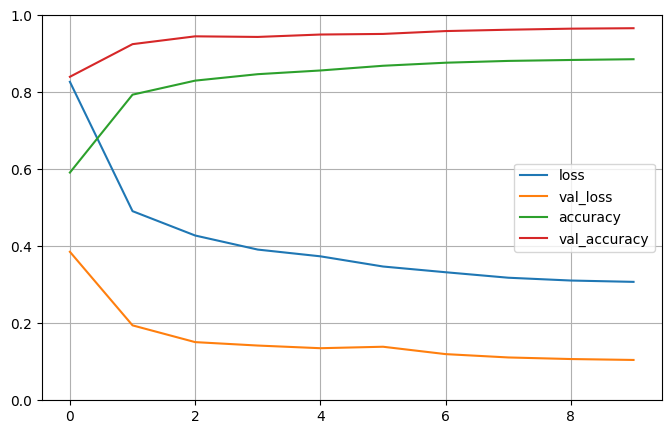

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

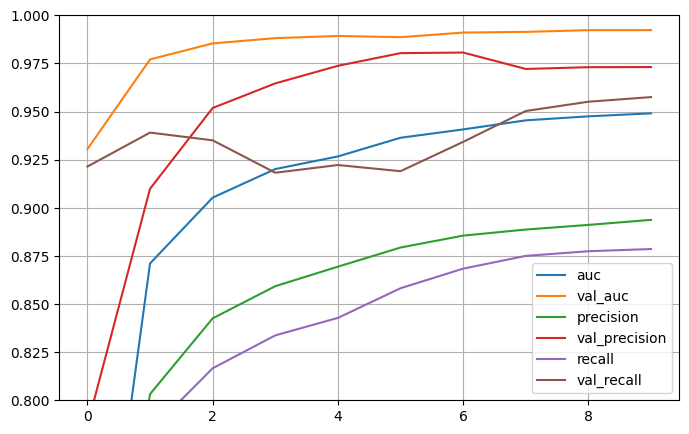

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

In [ ]:
#evaluate
model_txt_1_adamw.evaluate(ds_testing)

80/80 [==============================] - 6s 41ms/step - loss: 0.1243 - accuracy: 0.9586 - auc: 0.9903 - precision: 0.9686 - recall: 0.9493


[0.12431180477142334,
 0.9585937261581421,
 0.9902971386909485,
 0.9686274528503418,
 0.9492697715759277]

In [ ]:
{BUCKET_URI}/{FOLDER_MODEL}

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_v1_32_10_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}
!gsutil cp /content/model_v1_32_10_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_v1_32_10_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/640.4 MiB.                                    
Copying file:///content/model_v1_32_10_loss.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
si

## Model 1 v1 - AdamW
guardar como: model_v{version}_{batch_size}_{epochs}_{extra} <br>
- batch size: 16
- epochs: 10
- extra: no
- warmup: 10%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 16


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture

def model_v1(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt) #changed from 0.4 to 0.25

    #fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 10

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_txt_1_adamw = model_v1(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_v1_{BATCH_SIZE}_{NUM_EPOCHS}_loss.h5'
    filepath2 = f'model_v1_{BATCH_SIZE}_{NUM_EPOCHS}_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(0.1 * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_txt_1_adamw.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_txt_1_adamw.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7c7c06f05cf0> False
1 <keras.engine.input_layer.InputLayer object at 0x7c7c074cc8b0> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7c7c07357400> False
3 <keras.layers.pooling.global_max_pooling1d.GlobalMaxPooling1D object at 0x7c7c0742d660> True
4 <keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D object at 0x7c7c074cca30> True
5 <keras.layers.merging.concatenate.Concatenate object at 0x7c7c07455780> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7c7c07456d10> True
7 <keras.layers.core.dense.Dense object at 0x7c7c07457ee0> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7c7c074814e0> True
9 <keras.layers.regularization.dropout.Dropout object at 0x7c7c07456890> True
10 <keras.layers.core.dense.Dense object at 0x7c7c079b7ca0> True
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7c7

In [ ]:
start = time.time()


history_1 = model_txt_1_adamw.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/10


2612/2612 [==============================] - ETA: 0s - loss: 0.8749 - accuracy: 0.5317 - auc_1: 0.5453 - precision_1: 0.5370 - recall_1: 0.5300
Epoch 1: val_loss improved from inf to 0.91797, saving model to model_v1_16_10_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.63470, saving model to model_v1_16_10_acc.h5
2612/2612 [==============================] - 354s 107ms/step - loss: 0.8749 - accuracy: 0.5317 - auc_1: 0.5453 - precision_1: 0.5370 - recall_1: 0.5300 - val_loss: 0.9180 - val_accuracy: 0.6347 - val_auc_1: 0.6937 - val_precision_1: 0.6910 - val_recall_1: 0.4526
Epoch 2/10
2612/2612 [==============================] - ETA: 0s - loss: 0.7536 - accuracy: 0.6118 - auc_1: 0.6538 - precision_1: 0.6167 - recall_1: 0.6121
Epoch 2: val_loss improved from 0.91797 to 0.53848, saving model to model_v1_16_10_loss.h5

Epoch 2: val_accuracy improved from 0.63470 to 0.79193, saving model to model_v1_16_10_acc.h5
2612/2612 [==============================] - 230s 88ms/step - loss: 0.753

### Evaluating

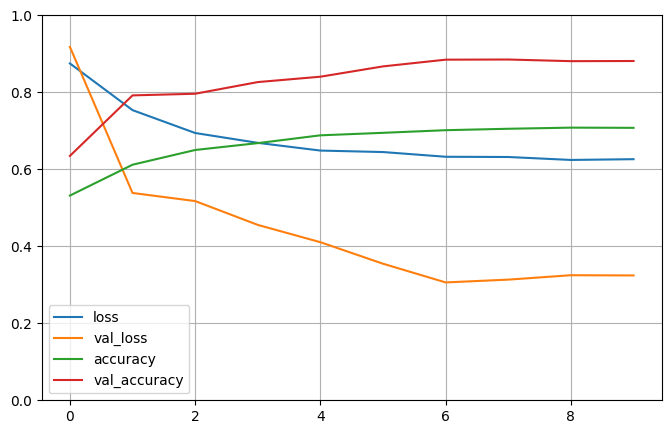

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

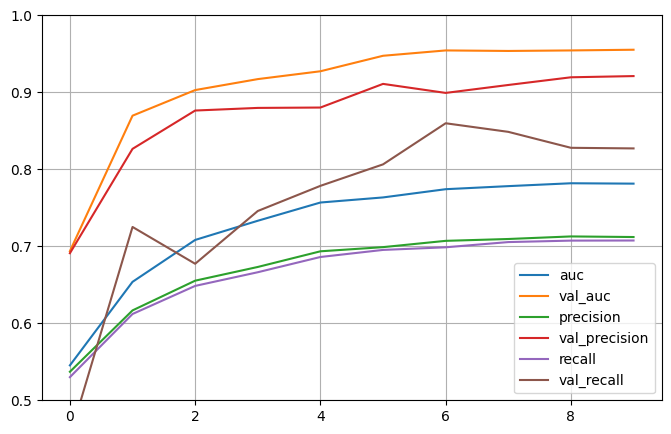

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc_1']
precision_recall['val_auc'] = history_1.history['val_auc_1']
precision_recall['precision'] = history_1.history['precision_1']
precision_recall['val_precision'] = history_1.history['val_precision_1']
precision_recall['recall'] = history_1.history['recall_1']
precision_recall['val_recall'] = history_1.history['val_recall_1']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.5,1)
plt.show()

In [ ]:
#evaluate
model_txt_1_adamw.evaluate(ds_testing)

161/161 [==============================] - 10s 30ms/step - loss: 0.3166 - accuracy: 0.8843 - auc_1: 0.9591 - precision_1: 0.9360 - recall_1: 0.8286


[0.316612184047699,
 0.8843167424201965,
 0.9590587615966797,
 0.9360414743423462,
 0.828615128993988]

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_v1_16_10_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}
!gsutil cp /content/model_v1_16_10_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_v1_16_10_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][640.4 MiB/640.4 MiB]                                                
Operation completed over 1 objects/640.4 MiB.                                    
Copying file:///content/model_v1_16_10_loss.h5 [Content-Type=application/x-hdf

## Model 1 v1 - AdamW
guardar como: model_v{version}_{batch_size}_{epochs}_{extra} <br>
- batch size: 16
- epochs: 30
- extra: no
- warmup: 10%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 16


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture

def model_v1(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt) #changed from 0.4 to 0.25

    #fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 30

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_txt_1_adamw = model_v1(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_v1_{BATCH_SIZE}_{NUM_EPOCHS}_loss.h5'
    filepath2 = f'model_v1_{BATCH_SIZE}_{NUM_EPOCHS}_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(0.1 * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_txt_1_adamw.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_txt_1_adamw.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7c7c0742ff40> False
1 <keras.engine.input_layer.InputLayer object at 0x7c7bff254c70> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7c7c047f70a0> False
3 <keras.layers.pooling.global_max_pooling1d.GlobalMaxPooling1D object at 0x7c7bff6d52d0> True
4 <keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D object at 0x7c7bff107880> True
5 <keras.layers.merging.concatenate.Concatenate object at 0x7c7bff3fa650> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7c7bff3cadd0> True
7 <keras.layers.core.dense.Dense object at 0x7c7bff286b60> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7c7bff3f9540> True
9 <keras.layers.regularization.dropout.Dropout object at 0x7c7bff285ab0> True
10 <keras.layers.core.dense.Dense object at 0x7c7bffb2f400> True
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7c7

In [ ]:
start = time.time()


history_1 = model_txt_1_adamw.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/30


2612/2612 [==============================] - ETA: 0s - loss: 0.9138 - accuracy: 0.5117 - auc_2: 0.5167 - precision_2: 0.5169 - recall_2: 0.5116
Epoch 1: val_loss improved from inf to 1.13599, saving model to model_v1_16_30_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.55357, saving model to model_v1_16_30_acc.h5
2612/2612 [==============================] - 325s 94ms/step - loss: 0.9138 - accuracy: 0.5117 - auc_2: 0.5167 - precision_2: 0.5169 - recall_2: 0.5116 - val_loss: 1.1360 - val_accuracy: 0.5536 - val_auc_2: 0.5934 - val_precision_2: 0.5349 - val_recall_2: 0.6406
Epoch 2/30
2612/2612 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.5682 - auc_2: 0.5963 - precision_2: 0.5735 - recall_2: 0.5667
Epoch 2: val_loss improved from 1.13599 to 0.75695, saving model to model_v1_16_30_loss.h5

Epoch 2: val_accuracy improved from 0.55357 to 0.70575, saving model to model_v1_16_30_acc.h5
2612/2612 [==============================] - 229s 88ms/step - loss: 0.8212

### Evaluating

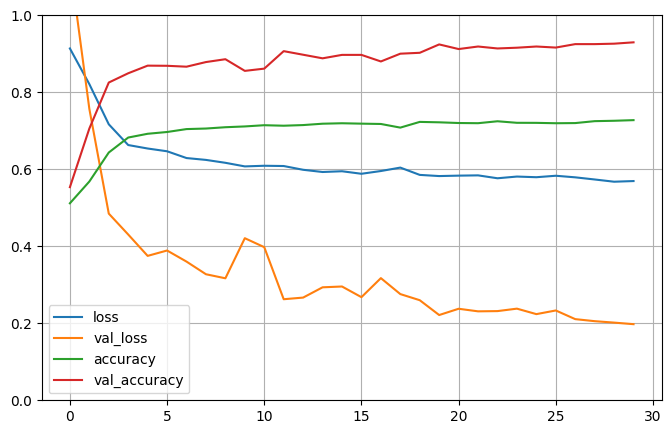

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

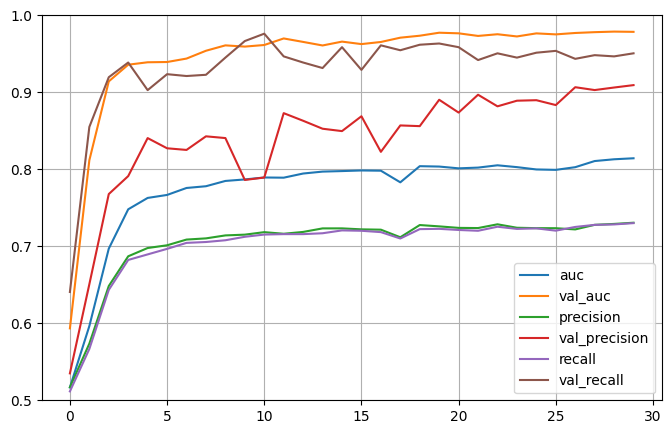

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc_2']
precision_recall['val_auc'] = history_1.history['val_auc_2']
precision_recall['precision'] = history_1.history['precision_2']
precision_recall['val_precision'] = history_1.history['val_precision_2']
precision_recall['recall'] = history_1.history['recall_2']
precision_recall['val_recall'] = history_1.history['val_recall_2']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.5,1)
plt.show()

In [ ]:
#evaluate
model_txt_1_adamw.evaluate(ds_testing)

161/161 [==============================] - 6s 27ms/step - loss: 0.1785 - accuracy: 0.9352 - auc_2: 0.9805 - precision_2: 0.9286 - recall_2: 0.9449


[0.17847493290901184,
 0.9351708292961121,
 0.9805017113685608,
 0.9285714030265808,
 0.9449120163917542]

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_v1_16_30_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}
!gsutil cp /content/model_v1_16_30_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_v1_16_30_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][640.4 MiB/640.4 MiB]                                                
Operation completed over 1 objects/640.4 MiB.                                    
Copying file:///content/model_v1_16_30_loss.h5 [Content-Type=application/x-hdf

## Model 1 v1 - AdamW ** SEGUNDO MEJOR POR AHORA**
guardar como: model_v{version}_{batch_size}_{epochs}_{extra} <br>
- batch size: 16
- epochs: 50
- extra: no
- warmup: 10%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 16


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture

def model_v1(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt) #changed from 0.4 to 0.25

    #fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 50

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_txt_1_adamw = model_v1(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_v1_{BATCH_SIZE}_{NUM_EPOCHS}_loss.h5'
    filepath2 = f'model_v1_{BATCH_SIZE}_{NUM_EPOCHS}_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(0.1 * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_txt_1_adamw.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_txt_1_adamw.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x79dc5fe804c0> False
1 <keras.engine.input_layer.InputLayer object at 0x79dc5f2a6530> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x79dc5fe80a90> False
3 <keras.layers.pooling.global_max_pooling1d.GlobalMaxPooling1D object at 0x79dc5d484fa0> True
4 <keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D object at 0x79dc5f404430> True
5 <keras.layers.merging.concatenate.Concatenate object at 0x79dc5cc80a30> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x79dc5fa9f970> True
7 <keras.layers.core.dense.Dense object at 0x79dc5fd46920> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x79dc5f3210c0> True
9 <keras.layers.regularization.dropout.Dropout object at 0x79dd4d08c460> True
10 <keras.layers.core.dense.Dense object at 0x79dc5f2b5900> True
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x79d

In [ ]:
start = time.time()


history_1 = model_txt_1_adamw.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/50


2612/2612 [==============================] - ETA: 0s - loss: 1.0075 - accuracy: 0.4854 - auc: 0.4775 - precision: 0.4907 - recall: 0.4865
Epoch 1: val_loss improved from inf to 1.42935, saving model to model_v1_16_50_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.50272, saving model to model_v1_16_50_acc.h5
2612/2612 [==============================] - 318s 92ms/step - loss: 1.0075 - accuracy: 0.4854 - auc: 0.4775 - precision: 0.4907 - recall: 0.4865 - val_loss: 1.4294 - val_accuracy: 0.5027 - val_auc: 0.5245 - val_precision: 0.4922 - val_recall: 0.6534
Epoch 2/50
2612/2612 [==============================] - ETA: 0s - loss: 0.9078 - accuracy: 0.5309 - auc: 0.5408 - precision: 0.5360 - recall: 0.5311
Epoch 2: val_loss improved from 1.42935 to 0.98063, saving model to model_v1_16_50_loss.h5

Epoch 2: val_accuracy improved from 0.50272 to 0.65062, saving model to model_v1_16_50_acc.h5
2612/2612 [==============================] - 236s 90ms/step - loss: 0.9078 - accuracy: 0.5309 - au

### Evaluating

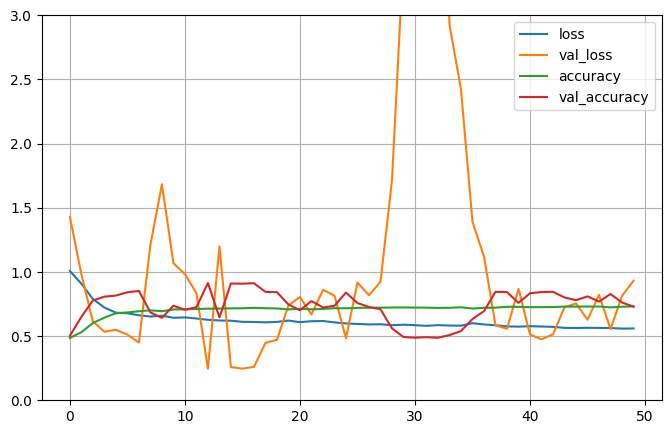

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
plt.show()

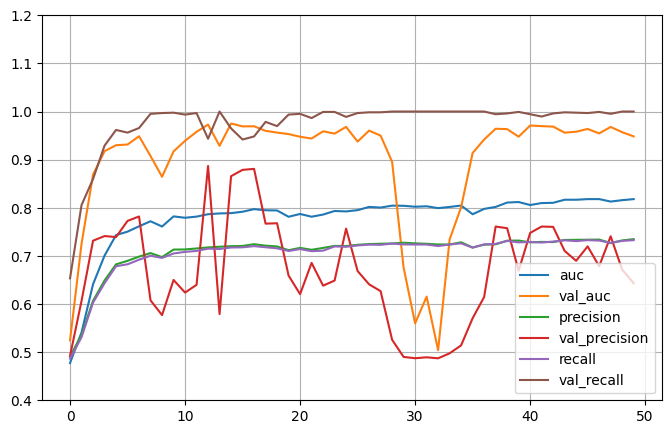

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.4,1.2)
plt.show()

In [ ]:
#evaluate
model_txt_1_adamw.evaluate(ds_testing)

161/161 [==============================] - 8s 35ms/step - loss: 0.8071 - accuracy: 0.7558 - auc: 0.9563 - precision: 0.6756 - recall: 0.9977


[0.807070255279541,
 0.7558229565620422,
 0.9563473463058472,
 0.6756476759910583,
 0.9977046847343445]

In [ ]:
model_txt_1_adamw.save_weights('model_v1_16_50_last_epoch.h5')

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_v1_16_50_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}
!gsutil cp /content/model_v1_16_50_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}
!gsutil cp /content/model_v1_16_50_last_epoch.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_v1_16_50_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][640.4 MiB/640.4 MiB]   57.7 MiB/s                                   
Operation completed over 1 objects/640.4 MiB.                                    
Copying file:///content/model_v1_16_50_loss.h5 [Content-Type=application/x-hdf

## Model 1 v1 - AdamW --- SAMPLE (50%) Training dataset
guardar como: model_v{version}_{batch_size}_{epochs}_{extra} <br>
- batch size: 32
- epochs: 10
- extra: no
- warmup: 10%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 32


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_sample_25-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_sample_25-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_sample_25-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(len(ds_train_sample) // BATCH_SIZE) #len(y_train) = 41794//2  ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture

def model_v1(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt) #changed from 0.4 to 0.25

    #fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 10

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_txt_1_adamw = model_v1(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_v1_{BATCH_SIZE}_{NUM_EPOCHS}_sample_loss.h5'
    filepath2 = f'model_v1_{BATCH_SIZE}_{NUM_EPOCHS}_sample_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train_sample)                      ##TRAIN SAMPLE OJO
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(0.1 * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_txt_1_adamw.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_txt_1_adamw.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7a53084791e0> False
1 <keras.engine.input_layer.InputLayer object at 0x7a52cd2635e0> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7a5308479ba0> False
3 <keras.layers.pooling.global_max_pooling1d.GlobalMaxPooling1D object at 0x7a52cc5a76a0> True
4 <keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D object at 0x7a52cc4a7610> True
5 <keras.layers.merging.concatenate.Concatenate object at 0x7a52cd5808e0> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7a52cd5816f0> True
7 <keras.layers.core.dense.Dense object at 0x7a52cd41b970> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7a52cd419de0> True
9 <keras.layers.regularization.dropout.Dropout object at 0x7a52cd3af640> True
10 <keras.layers.core.dense.Dense object at 0x7a52cd3ad720> True
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7a5

In [ ]:
start = time.time()


history_1 = model_txt_1_adamw.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/10


653/653 [==============================] - ETA: 0s - loss: 0.8295 - accuracy: 0.5675 - auc: 0.5936 - precision: 0.5708 - recall: 0.5648
Epoch 1: val_loss improved from inf to 0.54100, saving model to model_v1_32_10_sample_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.74063, saving model to model_v1_32_10_sample_acc.h5
653/653 [==============================] - 157s 121ms/step - loss: 0.8295 - accuracy: 0.5675 - auc: 0.5936 - precision: 0.5708 - recall: 0.5648 - val_loss: 0.5410 - val_accuracy: 0.7406 - val_auc: 0.8457 - val_precision: 0.6821 - val_recall: 0.8757
Epoch 2/10
653/653 [==============================] - ETA: 0s - loss: 0.5539 - accuracy: 0.7369 - auc: 0.8156 - precision: 0.7394 - recall: 0.7364
Epoch 2: val_loss improved from 0.54100 to 0.29435, saving model to model_v1_32_10_sample_loss.h5

Epoch 2: val_accuracy improved from 0.74063 to 0.87344, saving model to model_v1_32_10_sample_acc.h5
653/653 [==============================] - 65s 100ms/step - loss: 0.5539 - 

### Evaluating

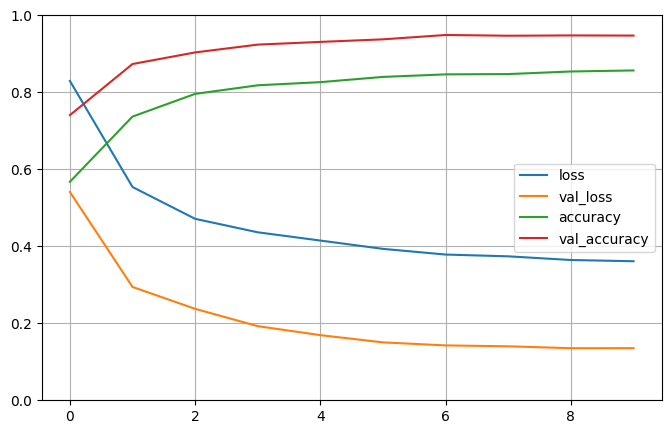

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

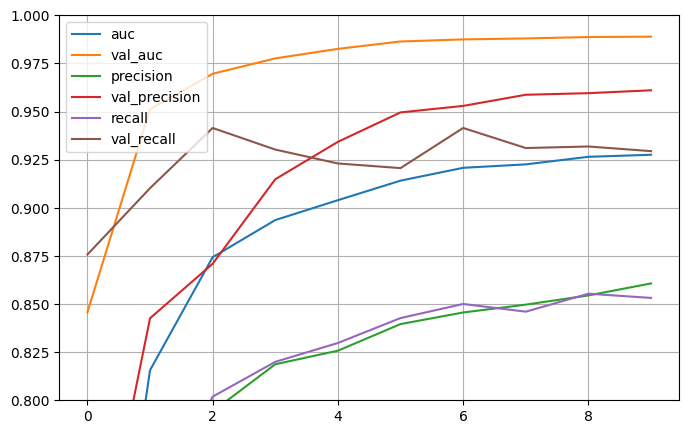

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

In [ ]:
#evaluate
model_txt_1_adamw.evaluate(ds_testing)

80/80 [==============================] - 4s 32ms/step - loss: 0.1353 - accuracy: 0.9488 - auc: 0.9899 - precision: 0.9725 - recall: 0.9254


[0.13529875874519348,
 0.9488281011581421,
 0.9898925423622131,
 0.9725363254547119,
 0.9254419803619385]

In [ ]:
{BUCKET_URI}/{FOLDER_MODEL}

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_v1_32_10_sample_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}
!gsutil cp /content/model_v1_32_10_sample_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_v1_32_10_sample_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/640.4 MiB.                                    
Copying file:///content/model_v1_32_10_sample_loss.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), whic

## Model 1 v1 - AdamW
guardar como: model_v{version}_{batch_size}_{epochs}_{extra} <br>
- batch size: 32
- epochs: 50
- extra: no
- warmup: 10%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 32


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture

def model_v1(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt) #changed from 0.4 to 0.25

    #fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 50

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_txt_1_adamw = model_v1(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_v1_{BATCH_SIZE}_{NUM_EPOCHS}_loss.h5'
    filepath2 = f'model_v1_{BATCH_SIZE}_{NUM_EPOCHS}_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(0.1 * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_txt_1_adamw.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_txt_1_adamw.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7bfb8d5af2b0> False
1 <keras.engine.input_layer.InputLayer object at 0x7bfb8d5d6200> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7bfb8d5d4430> False
3 <keras.layers.pooling.global_max_pooling1d.GlobalMaxPooling1D object at 0x7bfb8cedcd90> True
4 <keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D object at 0x7bfb880d4af0> True
5 <keras.layers.merging.concatenate.Concatenate object at 0x7bfb8d458e20> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bfb59551930> True
7 <keras.layers.core.dense.Dense object at 0x7bfb817bbe20> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bfb8cacd000> True
9 <keras.layers.regularization.dropout.Dropout object at 0x7bfb817e9cf0> True
10 <keras.layers.core.dense.Dense object at 0x7bfb8124cfa0> True
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bf

In [ ]:
start = time.time()


history_1 = model_txt_1_adamw.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/50


1306/1306 [==============================] - ETA: 0s - loss: 0.9176 - accuracy: 0.5203 - auc_1: 0.5284 - precision_1: 0.5256 - recall_1: 0.5187
Epoch 1: val_loss improved from inf to 0.62290, saving model to model_v1_32_50_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.67891, saving model to model_v1_32_50_acc.h5
1306/1306 [==============================] - 215s 106ms/step - loss: 0.9176 - accuracy: 0.5203 - auc_1: 0.5284 - precision_1: 0.5256 - recall_1: 0.5187 - val_loss: 0.6229 - val_accuracy: 0.6789 - val_auc_1: 0.7610 - val_precision_1: 0.6386 - val_recall_1: 0.7851
Epoch 2/50
1306/1306 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.6581 - auc_1: 0.7176 - precision_1: 0.6648 - recall_1: 0.6520
Epoch 2: val_loss improved from 0.62290 to 0.33557, saving model to model_v1_32_50_loss.h5

Epoch 2: val_accuracy improved from 0.67891 to 0.86406, saving model to model_v1_32_50_acc.h5
1306/1306 [==============================] - 125s 96ms/step - loss: 0.679

### Evaluating

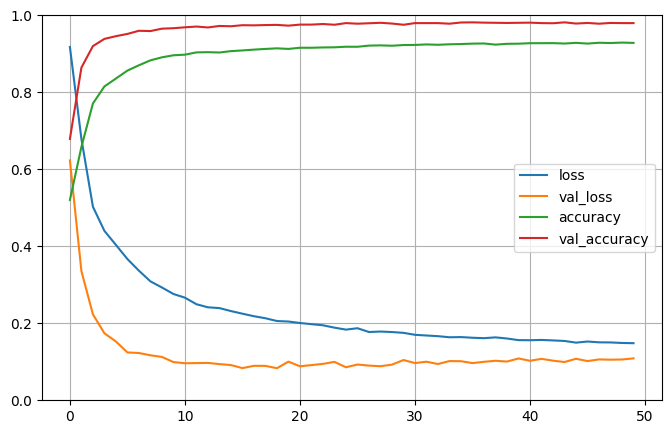

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

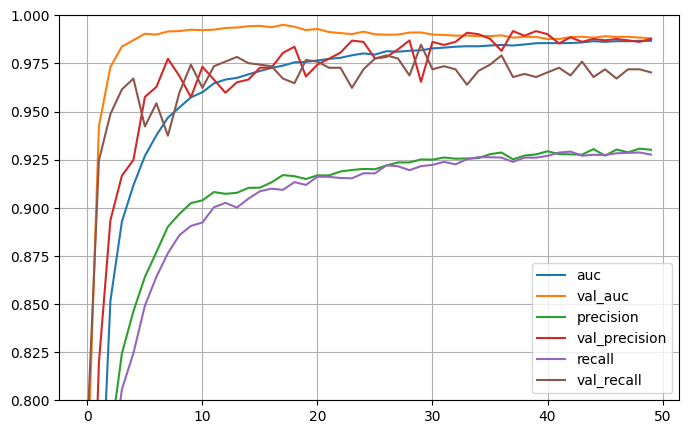

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc_1']
precision_recall['val_auc'] = history_1.history['val_auc_1']
precision_recall['precision'] = history_1.history['precision_1']
precision_recall['val_precision'] = history_1.history['val_precision_1']
precision_recall['recall'] = history_1.history['recall_1']
precision_recall['val_recall'] = history_1.history['val_recall_1']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

In [ ]:
#evaluate
model_txt_1_adamw.evaluate(ds_testing)

80/80 [==============================] - 4s 27ms/step - loss: 0.1143 - accuracy: 0.9773 - auc_1: 0.9887 - precision_1: 0.9875 - recall_1: 0.9677


[0.1142788678407669,
 0.977343738079071,
 0.988700270652771,
 0.9874509572982788,
 0.9677171111106873]

In [ ]:
{BUCKET_URI}/{FOLDER_MODEL}

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_v1_32_50_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}
!gsutil cp /content/model_v1_32_50_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_v1_32_50_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/640.4 MiB.                                    
Copying file:///content/model_v1_32_50_loss.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
si

## Model 2 v1 - AdamW + [CLS] tokens instead max&avgpooling
- batch size: 32
- epochs: 10
- extra: CLS
- warmup: 10%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 32


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture
def model_v2(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    cls_token_embedding = embedding_layer[:, 0, :]  # Extract the [CLS] token', Shape: (batch_size, hidden_size)

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(cls_token_embedding)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt)

    # Fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    # Output layer for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc)

    # Define the model
    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 10

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_2_v1 = model_v2(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_2_v1_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_loss.h5'
    filepath2 = f'model_2_v1_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_acc.h5'


    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(0.1 * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_2_v1.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_2_v1.layers):

  if index < 4: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False #bert + cls token frozen


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7be25844fc10> False
1 <keras.engine.input_layer.InputLayer object at 0x7be21c167250> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7be2584b9b40> False
3 <keras.layers.core.tf_op_layer.SlicingOpLambda object at 0x7be21c0d06a0> False
4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7be21c275960> True
5 <keras.layers.core.dense.Dense object at 0x7be21bb1cd00> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7be21c1512d0> True
7 <keras.layers.regularization.dropout.Dropout object at 0x7be21b9d24d0> True
8 <keras.layers.core.dense.Dense object at 0x7be21bc32110> True
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7be258629b70> True
10 <keras.layers.regularization.dropout.Dropout object at 0x7be21bc32c20> True
11 <keras.layers.core.dense.Dense object at 0x7be21bf76740> True


In [ ]:
start = time.time()


history_1 = model_2_v1.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/10


1306/1306 [==============================] - ETA: 0s - loss: 0.7621 - accuracy: 0.6058 - auc: 0.6495 - precision: 0.6105 - recall: 0.6069
Epoch 1: val_loss improved from inf to 0.28955, saving model to model_2_v1_32_10_CLS_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.86797, saving model to model_2_v1_32_10_CLS_acc.h5
1306/1306 [==============================] - 205s 97ms/step - loss: 0.7621 - accuracy: 0.6058 - auc: 0.6495 - precision: 0.6105 - recall: 0.6069 - val_loss: 0.2896 - val_accuracy: 0.8680 - val_auc: 0.9602 - val_precision: 0.8141 - val_recall: 0.9447
Epoch 2/10
1306/1306 [==============================] - ETA: 0s - loss: 0.4366 - accuracy: 0.8147 - auc: 0.8920 - precision: 0.8183 - recall: 0.8141
Epoch 2: val_loss improved from 0.28955 to 0.13813, saving model to model_2_v1_32_10_CLS_loss.h5

Epoch 2: val_accuracy improved from 0.86797 to 0.94805, saving model to model_2_v1_32_10_CLS_acc.h5
1306/1306 [==============================] - 121s 93ms/step - loss: 0.4366

### Evaluating

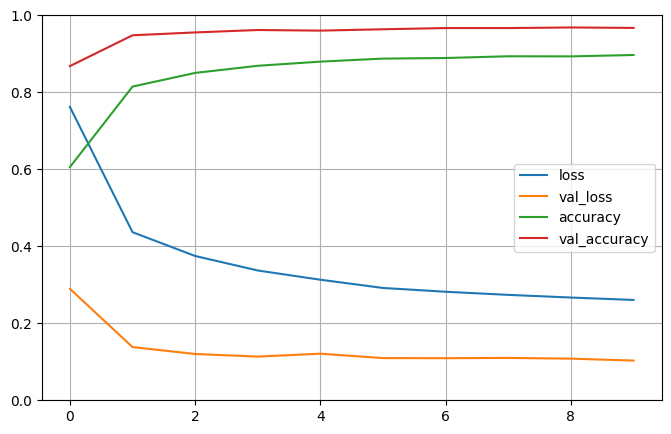

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

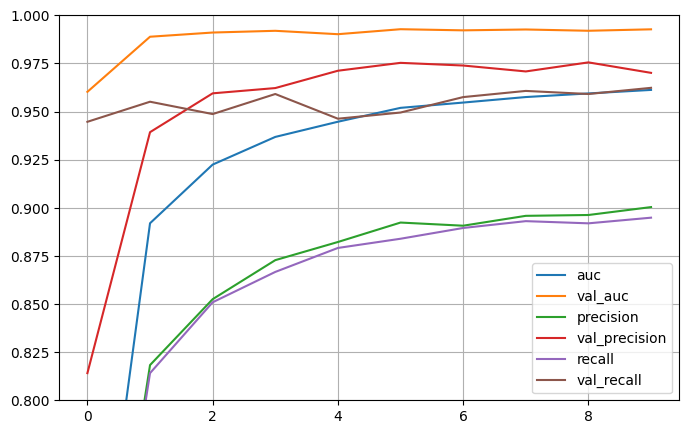

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

In [ ]:
#evaluate
model_2_v1.evaluate(ds_testing)

80/80 [==============================] - 6s 42ms/step - loss: 0.1187 - accuracy: 0.9652 - auc: 0.9919 - precision: 0.9712 - recall: 0.9600


[0.11872215569019318,
 0.9652343988418579,
 0.99188232421875,
 0.9712285995483398,
 0.960030734539032]

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_2_v1_32_10_CLS_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder} ##renamed to: se les agrego _cls_acc.h5 en buckets
!gsutil cp /content/model_2_v1_32_10_CLS_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_2_v1_32_10_CLS_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][639.6 MiB/639.6 MiB]                                                
Operation completed over 1 objects/639.6 MiB.                                    
Copying file:///content/model_2_v1_32_10_CLS_loss.h5 [Content-Type=appli

## Model 2 v1 - AdamW + [CLS] tokens instead max&avgpooling
- batch size: 16
- epochs: 30
- extra: CLS
- warmup: 10%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 16


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture
def model_v2(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    cls_token_embedding = embedding_layer[:, 0, :]  # Extract the [CLS] token', Shape: (batch_size, hidden_size)

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(cls_token_embedding)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt)

    # Fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    # Output layer for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc)

    # Define the model
    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 30

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_2_v1 = model_v2(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_2_v1_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_loss.h5'
    filepath2 = f'model_2_v1_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_acc.h5'


    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(0.1 * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_2_v1.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_2_v1.layers):

  if index < 4: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False #bert + cls token frozen


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x79dc585c8400> False
1 <keras.engine.input_layer.InputLayer object at 0x79dc58c05840> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x79dc585c8430> False
3 <keras.layers.core.tf_op_layer.SlicingOpLambda object at 0x79dc58c7ebc0> False
4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x79dc5fe80d30> True
5 <keras.layers.core.dense.Dense object at 0x79dc58c32e60> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x79dc58c7f670> True
7 <keras.layers.regularization.dropout.Dropout object at 0x79dc58bc5540> True
8 <keras.layers.core.dense.Dense object at 0x79dc58bc6e30> True
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x79dc5d325420> True
10 <keras.layers.regularization.dropout.Dropout object at 0x79dc58bc7220> True
11 <keras.layers.core.dense.Dense object at 0x79dc59ae0b80> True


In [ ]:
start = time.time()


history_1 = model_2_v1.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/30


2612/2612 [==============================] - ETA: 0s - loss: 0.9194 - accuracy: 0.5217 - auc_1: 0.5303 - precision_1: 0.5268 - recall_1: 0.5234
Epoch 1: val_loss improved from inf to 0.75458, saving model to model_2_v1_16_30_CLS_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.66770, saving model to model_2_v1_16_30_CLS_acc.h5
2612/2612 [==============================] - 317s 91ms/step - loss: 0.9194 - accuracy: 0.5217 - auc_1: 0.5303 - precision_1: 0.5268 - recall_1: 0.5234 - val_loss: 0.7546 - val_accuracy: 0.6677 - val_auc_1: 0.7321 - val_precision_1: 0.6418 - val_recall_1: 0.7195
Epoch 2/30
2612/2612 [==============================] - ETA: 0s - loss: 0.7534 - accuracy: 0.6192 - auc_1: 0.6651 - precision_1: 0.6236 - recall_1: 0.6213
Epoch 2: val_loss improved from 0.75458 to 0.37293, saving model to model_2_v1_16_30_CLS_loss.h5

Epoch 2: val_accuracy improved from 0.66770 to 0.85520, saving model to model_2_v1_16_30_CLS_acc.h5
2612/2612 [==============================] - 236s 

### Evaluating

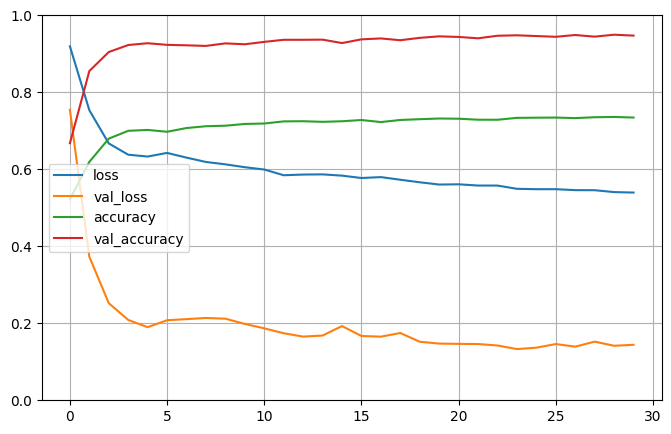

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

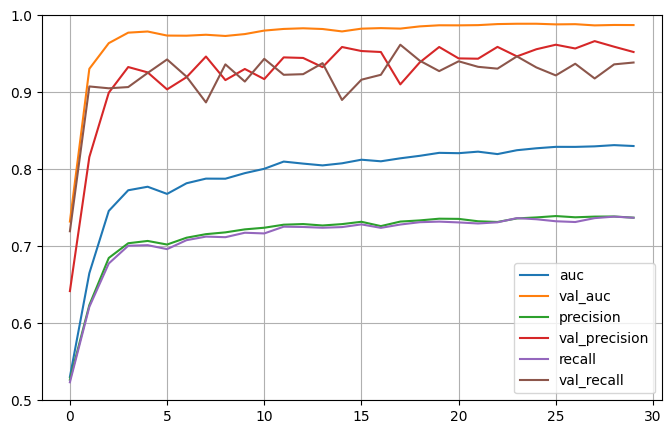

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc_1']
precision_recall['val_auc'] = history_1.history['val_auc_1']
precision_recall['precision'] = history_1.history['precision_1']
precision_recall['val_precision'] = history_1.history['val_precision_1']
precision_recall['recall'] = history_1.history['recall_1']
precision_recall['val_recall'] = history_1.history['val_recall_1']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.5,1)
plt.show()

In [ ]:
#evaluate
model_2_v1.evaluate(ds_testing)

161/161 [==============================] - 7s 29ms/step - loss: 0.1639 - accuracy: 0.9464 - auc_1: 0.9846 - precision_1: 0.9672 - recall_1: 0.9258


[0.16385041177272797,
 0.9464285969734192,
 0.9845768809318542,
 0.9672262072563171,
 0.9257842302322388]

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_2_v1_16_30_CLS_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder} ##renamed to: se les agrego _cls_acc.h5 en buckets
!gsutil cp /content/model_2_v1_16_30_CLS_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_2_v1_16_30_CLS_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][639.6 MiB/639.6 MiB]   50.1 MiB/s                                   
Operation completed over 1 objects/639.6 MiB.                                    
Copying file:///content/model_2_v1_16_30_CLS_loss.h5 [Content-Type=appli

## Model 2 v1 - AdamW + [CLS] tokens instead max&avgpooling
- batch size: 16
- epochs: 50
- extra: CLS
- warmup: 25%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 16


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture
def model_v2(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    cls_token_embedding = embedding_layer[:, 0, :]  # Extract the [CLS] token', Shape: (batch_size, hidden_size)

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(cls_token_embedding)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt)

    # Fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    # Output layer for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc)

    # Define the model
    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 50
warm_up = 0.25

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_2_v1 = model_v2(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_2_v1_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_loss.h5'
    filepath2 = f'model_2_v1_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_acc.h5'


    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(warm_up * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_2_v1.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_2_v1.layers):

  if index < 4: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False #bert + cls token frozen


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7822ee368970> False
1 <keras.engine.input_layer.InputLayer object at 0x7822ad3f0f40> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7822ee36b8e0> False
3 <keras.layers.core.tf_op_layer.SlicingOpLambda object at 0x7822ec0d7f10> False
4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x78239d4e5e40> True
5 <keras.layers.core.dense.Dense object at 0x7822ad6f1480> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7822ac4e54b0> True
7 <keras.layers.regularization.dropout.Dropout object at 0x7822ad310be0> True
8 <keras.layers.core.dense.Dense object at 0x7822ad074fa0> True
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7822ec03b460> True
10 <keras.layers.regularization.dropout.Dropout object at 0x7822ad075a80> True
11 <keras.layers.core.dense.Dense object at 0x7822ad0756c0> True


In [ ]:
start = time.time()


history_1 = model_2_v1.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/50


2612/2612 [==============================] - ETA: 0s - loss: 0.9615 - accuracy: 0.4999 - auc: 0.5023 - precision: 0.5051 - recall: 0.5024
Epoch 1: val_loss improved from inf to 1.11221, saving model to model_2_v1_16_50_CLS_wu_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.55241, saving model to model_2_v1_16_50_CLS_wu_acc.h5
2612/2612 [==============================] - 310s 88ms/step - loss: 0.9615 - accuracy: 0.4999 - auc: 0.5023 - precision: 0.5051 - recall: 0.5024 - val_loss: 1.1122 - val_accuracy: 0.5524 - val_auc: 0.5647 - val_precision: 0.5340 - val_recall: 0.6390
Epoch 2/50
2612/2612 [==============================] - ETA: 0s - loss: 0.8848 - accuracy: 0.5410 - auc: 0.5558 - precision: 0.5462 - recall: 0.5408
Epoch 2: val_loss improved from 1.11221 to 0.81264, saving model to model_2_v1_16_50_CLS_wu_loss.h5

Epoch 2: val_accuracy improved from 0.55241 to 0.66343, saving model to model_2_v1_16_50_CLS_wu_acc.h5
2612/2612 [==============================] - 226s 87ms/step - 

### Evaluating

In [ ]:
6975/3600

1.9375

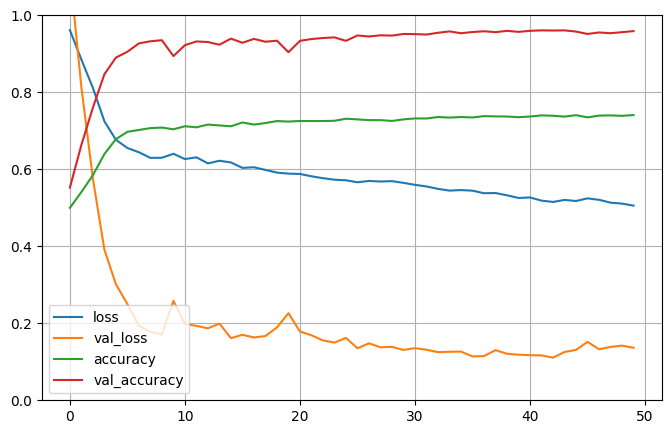

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

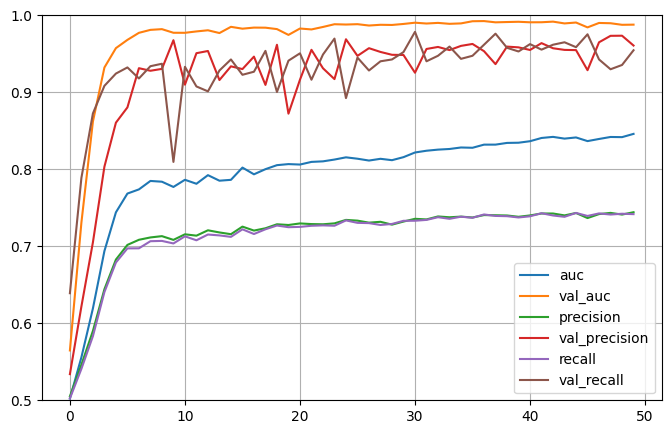

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.5,1)
plt.show()

In [ ]:
#evaluate
model_2_v1.evaluate(ds_testing)

161/161 [==============================] - 12s 42ms/step - loss: 0.1403 - accuracy: 0.9620 - auc: 0.9844 - precision: 0.9741 - recall: 0.9503


[0.1402611881494522,
 0.9619565010070801,
 0.9843559265136719,
 0.974117636680603,
 0.9502677917480469]

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_2_v1_16_50_CLS_wu_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder} ##renamed to: se les agrego _cls_acc.h5 en buckets
!gsutil cp /content/model_2_v1_16_50_CLS_wu_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_2_v1_16_50_CLS_wu_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][639.6 MiB/639.6 MiB]   57.2 MiB/s                                   
Operation completed over 1 objects/639.6 MiB.                                    
Copying file:///content/model_2_v1_16_50_CLS_wu_loss.h5 [Content-Type

## Model 3 v1 - AdamW + [CLS] modified architecture **MEJOR POR AHORA**
- batch size: 16
- epochs: 50
- extra:
  - CLS
  - only 1 dense layer (128)
  - only 1 dropout (50%)
- warmup: 25%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 16


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture
def model_v3(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    cls_token_embedding = embedding_layer[:, 0, :]  # Extract the [CLS] token', Shape: (batch_size, hidden_size)

    # Fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(cls_token_embedding)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.5, name='dropout_fc')(batch_norm_fc)

    # Output layer for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc)

    # Define the model
    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 50
warm_up = 0.25

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_3_v1 = model_v3(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_3_v1_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_loss.h5'
    filepath2 = f'model_3_v1_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_acc.h5'


    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(warm_up * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_3_v1.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_3_v1.layers):

  if index < 4: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False #bert + cls token frozen


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7c52382809a0> False
1 <keras.engine.input_layer.InputLayer object at 0x7c51ce9abf40> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7c51f9d36c50> False
3 <keras.layers.core.tf_op_layer.SlicingOpLambda object at 0x7c51f6f607c0> False
4 <keras.layers.core.dense.Dense object at 0x7c51f9d38a90> True
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7c52e7bd3340> True
6 <keras.layers.regularization.dropout.Dropout object at 0x7c51cea39000> True
7 <keras.layers.core.dense.Dense object at 0x7c51f9d377f0> True


In [ ]:
start = time.time()


history_1 = model_3_v1.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/50


2612/2612 [==============================] - ETA: 0s - loss: 0.8957 - accuracy: 0.5131 - auc: 0.5153 - precision: 0.5182 - recall: 0.5153
Epoch 1: val_loss improved from inf to 0.59061, saving model to model_3_v1_16_50_CLS_wu_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.65256, saving model to model_3_v1_16_50_CLS_wu_acc.h5
2612/2612 [==============================] - 307s 87ms/step - loss: 0.8957 - accuracy: 0.5131 - auc: 0.5153 - precision: 0.5182 - recall: 0.5153 - val_loss: 0.5906 - val_accuracy: 0.6526 - val_auc: 0.8501 - val_precision: 0.8982 - val_recall: 0.3235
Epoch 2/50
2612/2612 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.6494 - auc: 0.7103 - precision: 0.6557 - recall: 0.6443
Epoch 2: val_loss improved from 0.59061 to 0.26344, saving model to model_3_v1_16_50_CLS_wu_loss.h5

Epoch 2: val_accuracy improved from 0.65256 to 0.89480, saving model to model_3_v1_16_50_CLS_wu_acc.h5
2612/2612 [==============================] - 215s 82ms/step - 

### Evaluating

In [ ]:
6975/3600

1.9375

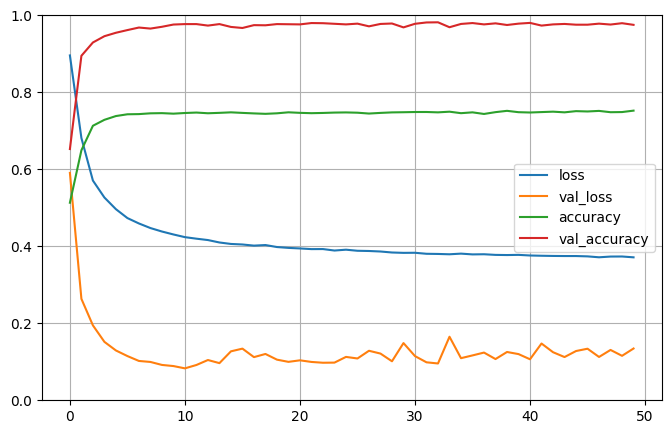

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

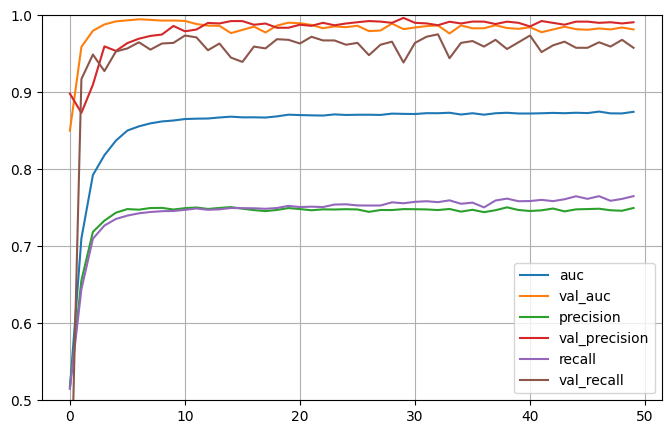

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.5,1)
plt.show()

In [ ]:
#evaluate
model_3_v1.evaluate(ds_testing)

161/161 [==============================] - 8s 35ms/step - loss: 0.1424 - accuracy: 0.9740 - auc: 0.9822 - precision: 0.9952 - recall: 0.9533


[0.14244891703128815,
 0.9739906787872314,
 0.9822273254394531,
 0.995207667350769,
 0.9533282518386841]

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_3_v1_16_50_CLS_wu_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder} ##renamed to: se les agrego _cls_acc.h5 en buckets
!gsutil cp /content/model_3_v1_16_50_CLS_wu_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_3_v1_16_50_CLS_wu_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][639.1 MiB/639.1 MiB]                                                
Operation completed over 1 objects/639.1 MiB.                                    
Copying file:///content/model_3_v1_16_50_CLS_wu_loss.h5 [Content-Type

## Model 3 v2 - AdamW + [CLS] modified architecture **SEGUNDO MEJOR POR AHORA**
- batch size: 16
- epochs: 50
- extra:
  - CLS
  - only 1 dense layer (64)
  - only 1 dropout (50%)
- warmup: 25%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 16


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture
def model_v3_2(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    cls_token_embedding = embedding_layer[:, 0, :]  # Extract the [CLS] token', Shape: (batch_size, hidden_size)

    # Fully connected layer
    dense_fc = tf.keras.layers.Dense(64, activation='relu', name='dense_fc')(cls_token_embedding)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.5, name='dropout_fc')(batch_norm_fc)

    # Output layer for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc)

    # Define the model
    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 50
warm_up = 0.25

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_3_v2 = model_v3_2(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_3_v2_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_loss.h5'
    filepath2 = f'model_3_v2_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_acc.h5'


    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(warm_up * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_3_v2.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_3_v2.layers):

  if index < 4: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False #bert + cls token frozen


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7d1d8d5b3dc0> False
1 <keras.engine.input_layer.InputLayer object at 0x7d1d8abf8760> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7d1d8d5b2110> False
3 <keras.layers.core.tf_op_layer.SlicingOpLambda object at 0x7d1d8ac00e20> False
4 <keras.layers.core.dense.Dense object at 0x7d1d8ac010f0> True
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7d1e7e5f7d90> True
6 <keras.layers.regularization.dropout.Dropout object at 0x7d1d8abfeec0> True
7 <keras.layers.core.dense.Dense object at 0x7d1d8a6feb90> True


In [ ]:
start = time.time()


history_1 = model_3_v2.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/50


2612/2612 [==============================] - ETA: 0s - loss: 0.8800 - accuracy: 0.5081 - auc: 0.5084 - precision: 0.5133 - recall: 0.5096
Epoch 1: val_loss improved from inf to 0.59632, saving model to model_3_v2_16_50_CLS_wu_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.69565, saving model to model_3_v2_16_50_CLS_wu_acc.h5
2612/2612 [==============================] - 324s 88ms/step - loss: 0.8800 - accuracy: 0.5081 - auc: 0.5084 - precision: 0.5133 - recall: 0.5096 - val_loss: 0.5963 - val_accuracy: 0.6957 - val_auc: 0.7746 - val_precision: 0.7302 - val_recall: 0.5952
Epoch 2/50
2612/2612 [==============================] - ETA: 0s - loss: 0.6998 - accuracy: 0.6266 - auc: 0.6779 - precision: 0.6322 - recall: 0.6239
Epoch 2: val_loss improved from 0.59632 to 0.28854, saving model to model_3_v2_16_50_CLS_wu_loss.h5

Epoch 2: val_accuracy improved from 0.69565 to 0.88160, saving model to model_3_v2_16_50_CLS_wu_acc.h5
2612/2612 [==============================] - 226s 87ms/step - 

### Evaluating

In [ ]:
6975/3600

1.9375

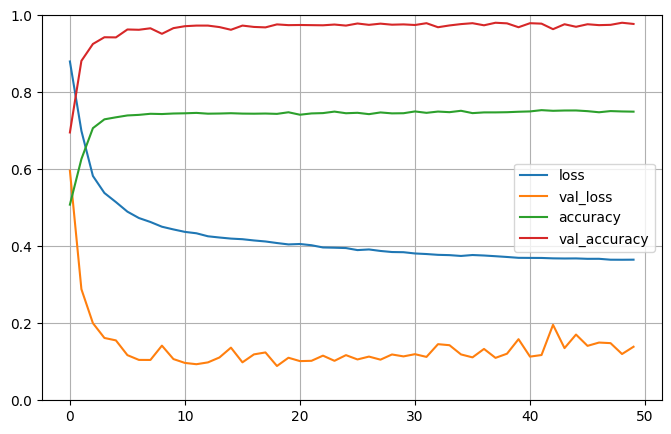

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

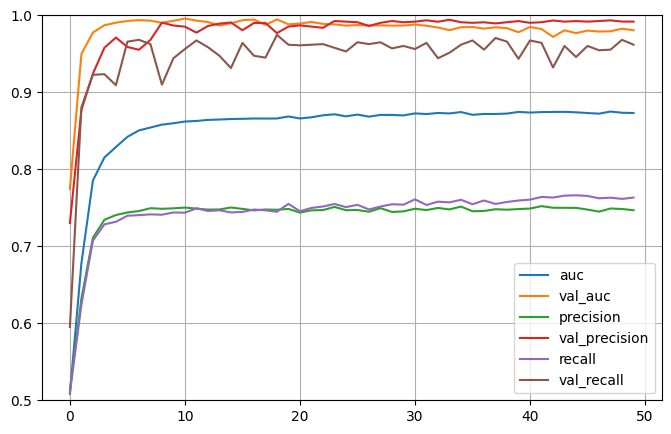

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.5,1)
plt.show()

In [ ]:
#evaluate
model_3_v2.evaluate(ds_testing)

161/161 [==============================] - 7s 28ms/step - loss: 0.1594 - accuracy: 0.9717 - auc: 0.9803 - precision: 0.9944 - recall: 0.9495


[0.15942160785198212,
 0.9716615080833435,
 0.9802928566932678,
 0.9943910241127014,
 0.94950270652771]

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_3_v2_16_50_CLS_wu_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder} ##renamed to: se les agrego _cls_acc.h5 en buckets
!gsutil cp /content/model_3_v2_16_50_CLS_wu_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_3_v2_16_50_CLS_wu_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][638.9 MiB/638.9 MiB]                                                
Operation completed over 1 objects/638.9 MiB.                                    
Copying file:///content/model_3_v2_16_50_CLS_wu_loss.h5 [Content-Type

## Model 3 v1 - AdamW + [CLS] modified architecture
- batch size: 16
- epochs: 100
- extra:
  - CLS
  - only 1 dense layer (128)
  - only 1 dropout (50%)
- warmup: 25%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 16


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture
def model_v3(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    cls_token_embedding = embedding_layer[:, 0, :]  # Extract the [CLS] token', Shape: (batch_size, hidden_size)

    # Fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(cls_token_embedding)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.5, name='dropout_fc')(batch_norm_fc)

    # Output layer for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc)

    # Define the model
    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 100
warm_up = 0.25

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_3_v1 = model_v3(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_3_v1_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_loss.h5'
    filepath2 = f'model_3_v1_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_acc.h5'


    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(warm_up * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_3_v1.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_3_v1.layers):

  if index < 4: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False #bert + cls token frozen


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7decac678d30> False
1 <keras.engine.input_layer.InputLayer object at 0x7deca45e01f0> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7dedebe86ce0> False
3 <keras.layers.core.tf_op_layer.SlicingOpLambda object at 0x7deca45e2ef0> False
4 <keras.layers.core.dense.Dense object at 0x7decb8410a00> True
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7dec77c41de0> True
6 <keras.layers.regularization.dropout.Dropout object at 0x7decac206a40> True
7 <keras.layers.core.dense.Dense object at 0x7deca45e3be0> True


In [ ]:
start = time.time()


history_1 = model_3_v1.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/100


2612/2612 [==============================] - ETA: 0s - loss: 0.8256 - accuracy: 0.5239 - auc: 0.5359 - precision: 0.5292 - recall: 0.5218
Epoch 1: val_loss improved from inf to 0.57697, saving model to model_3_v1_16_100_CLS_wu_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.73175, saving model to model_3_v1_16_100_CLS_wu_acc.h5
2612/2612 [==============================] - 312s 90ms/step - loss: 0.8256 - accuracy: 0.5239 - auc: 0.5359 - precision: 0.5292 - recall: 0.5218 - val_loss: 0.5770 - val_accuracy: 0.7318 - val_auc: 0.8042 - val_precision: 0.7278 - val_recall: 0.7179
Epoch 2/100
2612/2612 [==============================] - ETA: 0s - loss: 0.7336 - accuracy: 0.5996 - auc: 0.6402 - precision: 0.6048 - recall: 0.5987
Epoch 2: val_loss improved from 0.57697 to 0.33078, saving model to model_3_v1_16_100_CLS_wu_loss.h5

Epoch 2: val_accuracy improved from 0.73175 to 0.86025, saving model to model_3_v1_16_100_CLS_wu_acc.h5
2612/2612 [==============================] - 221s 85ms/st

### Evaluating

In [ ]:
6975/3600

1.9375

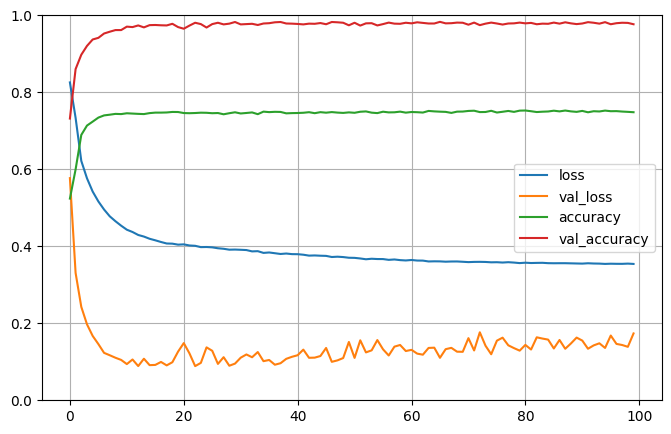

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

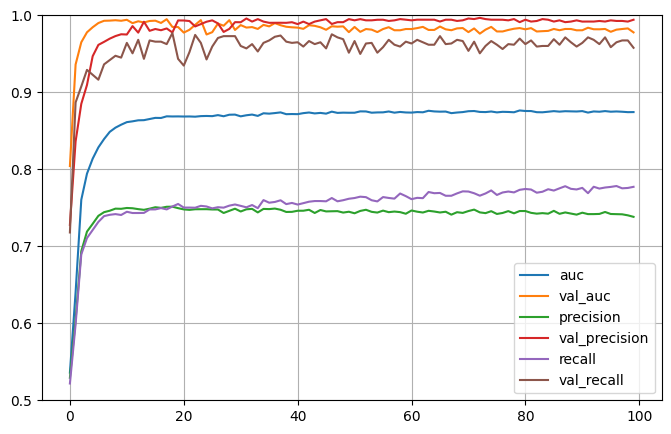

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.5,1)
plt.show()

In [ ]:
#evaluate
model_3_v1.evaluate(ds_testing)

161/161 [==============================] - 9s 42ms/step - loss: 0.1840 - accuracy: 0.9752 - auc: 0.9770 - precision: 0.9976 - recall: 0.9533


[0.18397831916809082,
 0.9751552939414978,
 0.9769670963287354,
 0.9975980520248413,
 0.9533282518386841]

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_3_v1_16_100_CLS_wu_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder} ##renamed to: se les agrego _cls_acc.h5 en buckets
!gsutil cp /content/model_3_v1_16_100_CLS_wu_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_3_v1_16_100_CLS_wu_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][639.1 MiB/639.1 MiB]   68.7 MiB/s                                   
Operation completed over 1 objects/639.1 MiB.                                    
Copying file:///content/model_3_v1_16_100_CLS_wu_loss.h5 [Content-Ty

## Model 3 v2 - AdamW + [CLS] modified architecture **SEGUNDO MEJOR POR AHORA**
- batch size: 16
- epochs: 50
- extra:
  - CLS
  - only 1 dense layer (64)
  - only 1 dropout (50%)
- warmup: 25%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 16


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture
def model_v3_2(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    cls_token_embedding = embedding_layer[:, 0, :]  # Extract the [CLS] token', Shape: (batch_size, hidden_size)

    # Fully connected layer
    dense_fc = tf.keras.layers.Dense(64, activation='relu', name='dense_fc')(cls_token_embedding)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.5, name='dropout_fc')(batch_norm_fc)

    # Output layer for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc)

    # Define the model
    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 50
warm_up = 0.25

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_3_v2 = model_v3_2(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_3_v2_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_loss.h5'
    filepath2 = f'model_3_v2_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_acc.h5'


    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(warm_up * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_3_v2.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_3_v2.layers):

  if index < 4: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False #bert + cls token frozen


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7d1d8d5b3dc0> False
1 <keras.engine.input_layer.InputLayer object at 0x7d1d8abf8760> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7d1d8d5b2110> False
3 <keras.layers.core.tf_op_layer.SlicingOpLambda object at 0x7d1d8ac00e20> False
4 <keras.layers.core.dense.Dense object at 0x7d1d8ac010f0> True
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7d1e7e5f7d90> True
6 <keras.layers.regularization.dropout.Dropout object at 0x7d1d8abfeec0> True
7 <keras.layers.core.dense.Dense object at 0x7d1d8a6feb90> True


In [ ]:
start = time.time()


history_1 = model_3_v2.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/50


2612/2612 [==============================] - ETA: 0s - loss: 0.8800 - accuracy: 0.5081 - auc: 0.5084 - precision: 0.5133 - recall: 0.5096
Epoch 1: val_loss improved from inf to 0.59632, saving model to model_3_v2_16_50_CLS_wu_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.69565, saving model to model_3_v2_16_50_CLS_wu_acc.h5
2612/2612 [==============================] - 324s 88ms/step - loss: 0.8800 - accuracy: 0.5081 - auc: 0.5084 - precision: 0.5133 - recall: 0.5096 - val_loss: 0.5963 - val_accuracy: 0.6957 - val_auc: 0.7746 - val_precision: 0.7302 - val_recall: 0.5952
Epoch 2/50
2612/2612 [==============================] - ETA: 0s - loss: 0.6998 - accuracy: 0.6266 - auc: 0.6779 - precision: 0.6322 - recall: 0.6239
Epoch 2: val_loss improved from 0.59632 to 0.28854, saving model to model_3_v2_16_50_CLS_wu_loss.h5

Epoch 2: val_accuracy improved from 0.69565 to 0.88160, saving model to model_3_v2_16_50_CLS_wu_acc.h5
2612/2612 [==============================] - 226s 87ms/step - 

### Evaluating

In [ ]:
6975/3600

1.9375

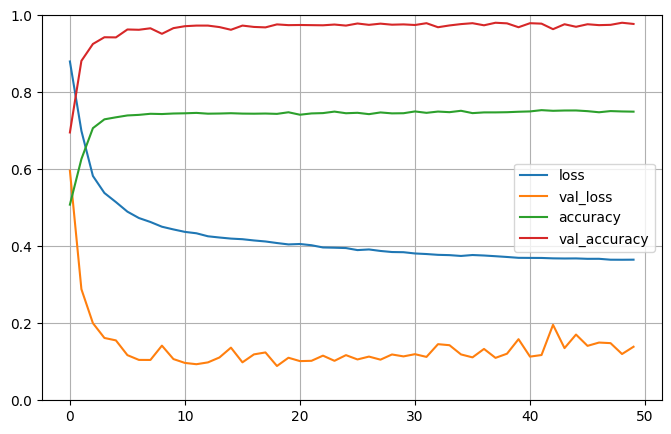

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

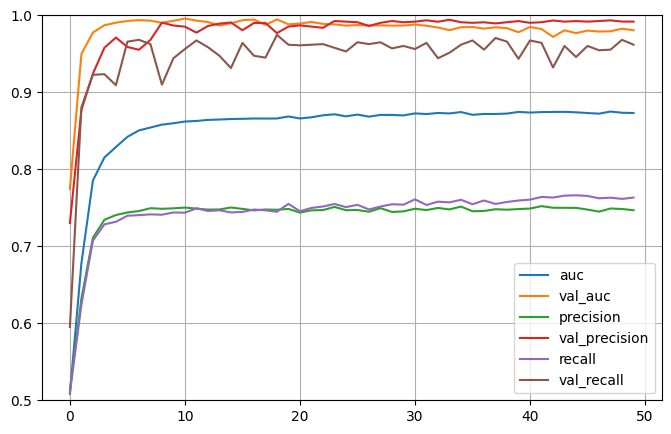

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.5,1)
plt.show()

In [ ]:
#evaluate
model_3_v2.evaluate(ds_testing)

161/161 [==============================] - 7s 28ms/step - loss: 0.1594 - accuracy: 0.9717 - auc: 0.9803 - precision: 0.9944 - recall: 0.9495


[0.15942160785198212,
 0.9716615080833435,
 0.9802928566932678,
 0.9943910241127014,
 0.94950270652771]

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_3_v2_16_50_CLS_wu_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder} ##renamed to: se les agrego _cls_acc.h5 en buckets
!gsutil cp /content/model_3_v2_16_50_CLS_wu_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_3_v2_16_50_CLS_wu_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][638.9 MiB/638.9 MiB]                                                
Operation completed over 1 objects/638.9 MiB.                                    
Copying file:///content/model_3_v2_16_50_CLS_wu_loss.h5 [Content-Type

## Model 3 v3 - AdamW + [CLS] modified architecture **
- batch size: 16
- epochs: 50
- extra:
  - CLS
  - only 1 dense layer (100)
  - only 1 dropout (50%)
- warmup: 25%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 16


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture
def model_v3_3(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    cls_token_embedding = embedding_layer[:, 0, :]  # Extract the [CLS] token', Shape: (batch_size, hidden_size)

    # Fully connected layer
    dense_fc = tf.keras.layers.Dense(100, activation='relu', name='dense_fc')(cls_token_embedding)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.5, name='dropout_fc')(batch_norm_fc)

    # Output layer for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc)

    # Define the model
    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 50
warm_up = 0.25

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_3_v3 = model_v3_3(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_3_v3_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_loss.h5'
    filepath2 = f'model_3_v3_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_acc.h5'


    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(warm_up * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_3_v3.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_3_v3.layers):

  if index < 4: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False #bert + cls token frozen


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x785e0a243a30> False
1 <keras.engine.input_layer.InputLayer object at 0x785de1faf070> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x785e48401d20> False
3 <keras.layers.core.tf_op_layer.SlicingOpLambda object at 0x785e09c7ba00> False
4 <keras.layers.core.dense.Dense object at 0x785e09e93190> True
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x785e09d81c90> True
6 <keras.layers.regularization.dropout.Dropout object at 0x785e09ce9d20> True
7 <keras.layers.core.dense.Dense object at 0x785e0a0d0a30> True


In [ ]:
start = time.time()


history_1 = model_3_v3.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/50


2612/2612 [==============================] - ETA: 0s - loss: 0.8525 - accuracy: 0.5136 - auc: 0.5187 - precision: 0.5188 - recall: 0.5137
Epoch 1: val_loss improved from inf to 0.56847, saving model to model_3_v3_16_50_CLS_wu_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.71390, saving model to model_3_v3_16_50_CLS_wu_acc.h5
2612/2612 [==============================] - 341s 95ms/step - loss: 0.8525 - accuracy: 0.5136 - auc: 0.5187 - precision: 0.5188 - recall: 0.5137 - val_loss: 0.5685 - val_accuracy: 0.7139 - val_auc: 0.8051 - val_precision: 0.6665 - val_recall: 0.8263
Epoch 2/50
2612/2612 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.6404 - auc: 0.7003 - precision: 0.6465 - recall: 0.6360
Epoch 2: val_loss improved from 0.56847 to 0.24092, saving model to model_3_v3_16_50_CLS_wu_loss.h5

Epoch 2: val_accuracy improved from 0.71390 to 0.89790, saving model to model_3_v3_16_50_CLS_wu_acc.h5
2612/2612 [==============================] - 233s 89ms/step - 

### Evaluating

In [ ]:
11408/3600

3.168888888888889

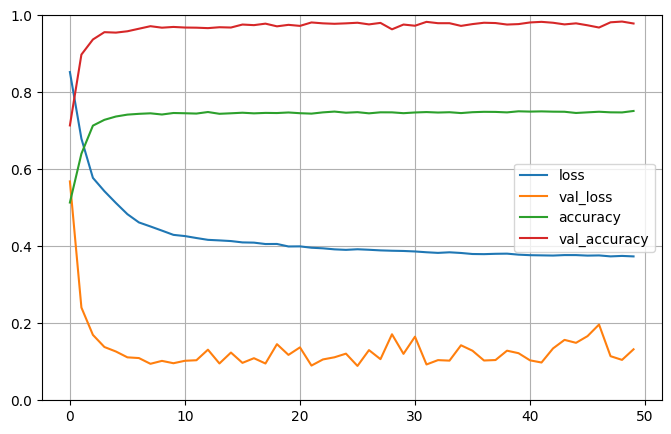

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

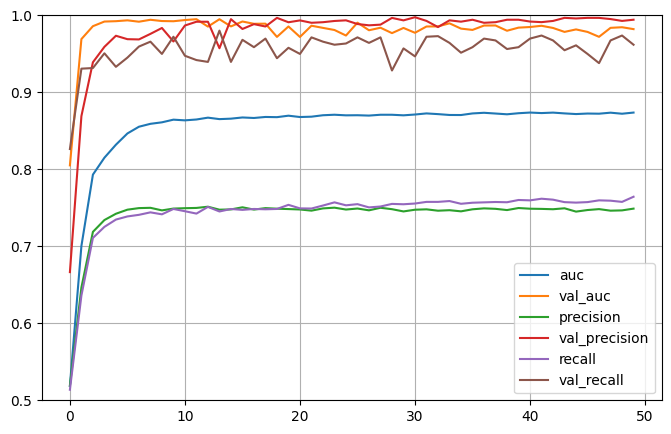

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.5,1)
plt.show()

In [ ]:
#evaluate
model_3_v3.evaluate(ds_testing)

161/161 [==============================] - 15s 44ms/step - loss: 0.1380 - accuracy: 0.9775 - auc: 0.9814 - precision: 0.9929 - recall: 0.9625


[0.13801538944244385,
 0.9774844646453857,
 0.9813904166221619,
 0.9928966164588928,
 0.9625095725059509]

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_3_v3_16_50_CLS_wu_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder} ##renamed to: se les agrego _cls_acc.h5 en buckets
!gsutil cp /content/model_3_v3_16_50_CLS_wu_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_3_v3_16_50_CLS_wu_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][639.0 MiB/639.0 MiB]   44.3 MiB/s                                   
Operation completed over 1 objects/639.0 MiB.                                    
Copying file:///content/model_3_v3_16_50_CLS_wu_loss.h5 [Content-Type

## Model 4 v1 - AdamW  (modelo 1 {max+avg pool} con prunning de layers)
guardar como: model_v{version}_{batch_size}_{epochs}_{extra} <br>
- batch size: 16
- epochs: 50
- extra:
  - only 1 dense layer (128)
  - only 1 dropout (50%)
- warmup: 25%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 16


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture

def model_v4(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    #fully connected layer
    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(batch_norm_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.5, name='dropout_fc')(batch_norm_fc)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 50
warm_up = 0.25

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_4_v1 = model_v4(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_4_v1_{BATCH_SIZE}_{NUM_EPOCHS}_loss.h5'
    filepath2 = f'model_4_v1_{BATCH_SIZE}_{NUM_EPOCHS}_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(warm_up * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_4_v1.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_4_v1.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7e2705ef2e30> False
1 <keras.engine.input_layer.InputLayer object at 0x7e26c4f86710> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7e283d9ef910> False
3 <keras.layers.pooling.global_max_pooling1d.GlobalMaxPooling1D object at 0x7e26c47c9210> True
4 <keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D object at 0x7e26c4edf640> True
5 <keras.layers.merging.concatenate.Concatenate object at 0x7e26c4f7ad10> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7e26c4901390> True
7 <keras.layers.core.dense.Dense object at 0x7e26c4f74520> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7e26c4f7b1c0> True
9 <keras.layers.regularization.dropout.Dropout object at 0x7e26c4b605b0> True
10 <keras.layers.core.dense.Dense object at 0x7e26c4ea3eb0> True


In [ ]:
start = time.time()


history_1 = model_4_v1.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/50


2612/2612 [==============================] - ETA: 0s - loss: 0.9782 - accuracy: 0.5329 - auc: 0.5460 - precision: 0.5381 - recall: 0.5329
Epoch 1: val_loss improved from inf to 0.75394, saving model to model_v1_16_50_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.66925, saving model to model_v1_16_50_acc.h5
2612/2612 [==============================] - 307s 86ms/step - loss: 0.9782 - accuracy: 0.5329 - auc: 0.5460 - precision: 0.5381 - recall: 0.5329 - val_loss: 0.7539 - val_accuracy: 0.6693 - val_auc: 0.7327 - val_precision: 0.6782 - val_recall: 0.6112
Epoch 2/50
2612/2612 [==============================] - ETA: 0s - loss: 0.8698 - accuracy: 0.5879 - auc: 0.6242 - precision: 0.5926 - recall: 0.5897
Epoch 2: val_loss improved from 0.75394 to 0.45499, saving model to model_v1_16_50_loss.h5

Epoch 2: val_accuracy improved from 0.66925 to 0.80745, saving model to model_v1_16_50_acc.h5
2612/2612 [==============================] - 218s 84ms/step - loss: 0.8698 - accuracy: 0.5879 - au

### Evaluating

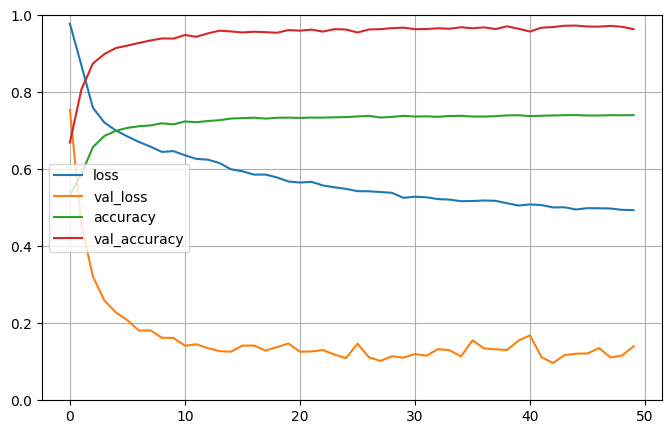

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

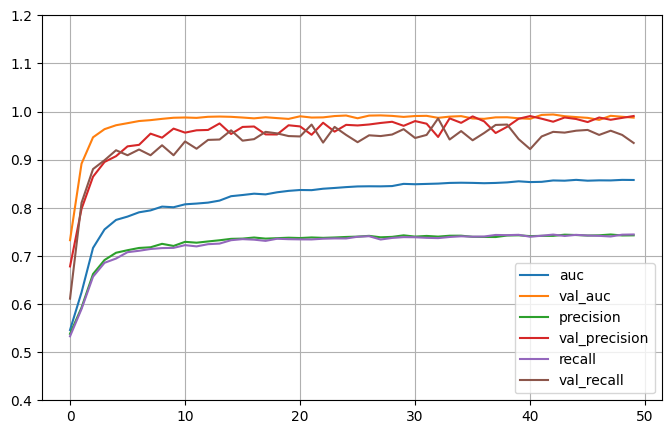

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.4,1.2)
plt.show()

In [ ]:
#evaluate
model_4_v1.evaluate(ds_testing)

161/161 [==============================] - 8s 38ms/step - loss: 0.1637 - accuracy: 0.9581 - auc: 0.9863 - precision: 0.9862 - recall: 0.9304


[0.16373306512832642,
 0.9580745100975037,
 0.9862816333770752,
 0.9862124919891357,
 0.9303749203681946]

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_4_v1_16_50_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}
!gsutil cp /content/model_4_v1_16_50_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}


Copying file:///content/model_4_v1_16_50_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][639.5 MiB/639.5 MiB]                                                
Operation completed over 1 objects/639.5 MiB.                                    
Copying file:///content/model_4_v1_16_50_loss.h5 [Content-Type=application/x

## Model 3 v2 - AdamW + [CLS] modified architecture
- batch size: 16
- epochs: 50
- extra:
  - CLS
  - only 1 dense layer (128)
  - only 1 dropout (50%)
- warmup: 25%

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 16


ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_train_hybrid_24-06-24_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(41794 // BATCH_SIZE) #len(y_train) = 41794 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_eval_hybrid_24-06-24_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(2587 // BATCH_SIZE) #len(y_valid) = 2587
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p1.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p2.tfrecords",
                                       f"{BUCKET_URI}/{FOLDER_MODEL}/{TF_RECORDS_DATASETS}/ds_test_hybrid_24-06-24_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

### training

In [ ]:
#model architecture
def model_v3(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    cls_token_embedding = embedding_layer[:, 0, :]  # Extract the [CLS] token', Shape: (batch_size, hidden_size)

    # Fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(cls_token_embedding)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.5, name='dropout_fc')(batch_norm_fc)

    # Output layer for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc)

    # Define the model
    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 100
warm_up = 0.25

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_3_v1 = model_v3(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = f'model_3_v1_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_loss.h5'
    filepath2 = f'model_3_v1_{BATCH_SIZE}_{NUM_EPOCHS}_CLS_wu_acc.h5'


    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(warm_up * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_3_v1.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_3_v1.layers):

  if index < 4: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False #bert + cls token frozen


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7decac678d30> False
1 <keras.engine.input_layer.InputLayer object at 0x7deca45e01f0> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7dedebe86ce0> False
3 <keras.layers.core.tf_op_layer.SlicingOpLambda object at 0x7deca45e2ef0> False
4 <keras.layers.core.dense.Dense object at 0x7decb8410a00> True
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7dec77c41de0> True
6 <keras.layers.regularization.dropout.Dropout object at 0x7decac206a40> True
7 <keras.layers.core.dense.Dense object at 0x7deca45e3be0> True


In [ ]:
start = time.time()


history_1 = model_3_v1.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/100


2612/2612 [==============================] - ETA: 0s - loss: 0.8256 - accuracy: 0.5239 - auc: 0.5359 - precision: 0.5292 - recall: 0.5218
Epoch 1: val_loss improved from inf to 0.57697, saving model to model_3_v1_16_100_CLS_wu_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.73175, saving model to model_3_v1_16_100_CLS_wu_acc.h5
2612/2612 [==============================] - 312s 90ms/step - loss: 0.8256 - accuracy: 0.5239 - auc: 0.5359 - precision: 0.5292 - recall: 0.5218 - val_loss: 0.5770 - val_accuracy: 0.7318 - val_auc: 0.8042 - val_precision: 0.7278 - val_recall: 0.7179
Epoch 2/100
2612/2612 [==============================] - ETA: 0s - loss: 0.7336 - accuracy: 0.5996 - auc: 0.6402 - precision: 0.6048 - recall: 0.5987
Epoch 2: val_loss improved from 0.57697 to 0.33078, saving model to model_3_v1_16_100_CLS_wu_loss.h5

Epoch 2: val_accuracy improved from 0.73175 to 0.86025, saving model to model_3_v1_16_100_CLS_wu_acc.h5
2612/2612 [==============================] - 221s 85ms/st

### Evaluating

In [ ]:
6975/3600

1.9375

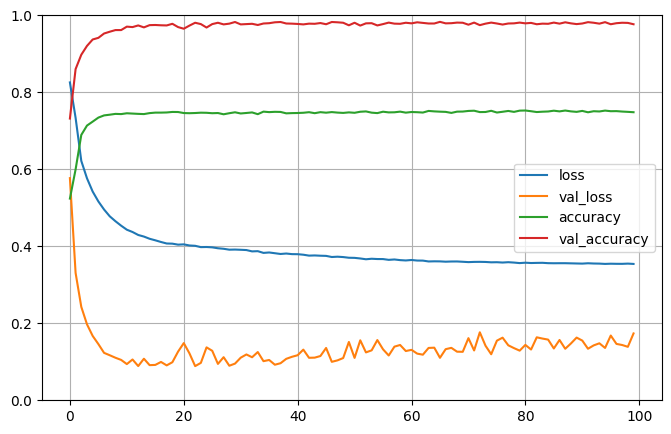

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

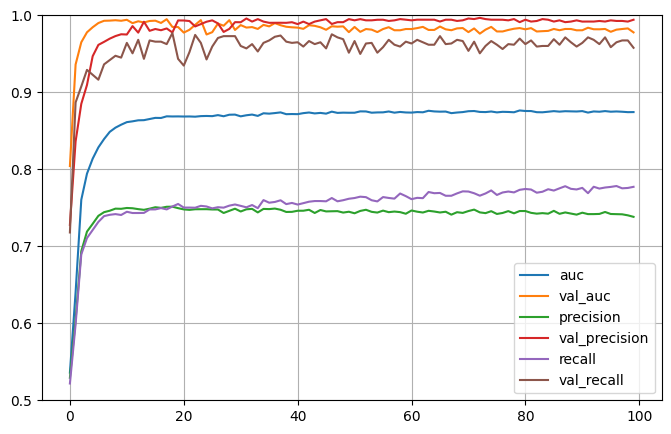

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.5,1)
plt.show()

In [ ]:
#evaluate
model_3_v1.evaluate(ds_testing)

161/161 [==============================] - 9s 42ms/step - loss: 0.1840 - accuracy: 0.9752 - auc: 0.9770 - precision: 0.9976 - recall: 0.9533


[0.18397831916809082,
 0.9751552939414978,
 0.9769670963287354,
 0.9975980520248413,
 0.9533282518386841]

In [ ]:
models_folder = 'model_checkpoints'
!gsutil cp /content/model_3_v1_16_100_CLS_wu_acc.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder} ##renamed to: se les agrego _cls_acc.h5 en buckets
!gsutil cp /content/model_3_v1_16_100_CLS_wu_loss.h5 {BUCKET_URI}/{FOLDER_MODEL}/{models_folder}

Copying file:///content/model_3_v1_16_100_CLS_wu_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][639.1 MiB/639.1 MiB]   68.7 MiB/s                                   
Operation completed over 1 objects/639.1 MiB.                                    
Copying file:///content/model_3_v1_16_100_CLS_wu_loss.h5 [Content-Ty